In [1]:
import torch
from dataset_class import dataset,params2theta,theta2params
#import dataset_class as dc
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
def load_dataset(filename,Nmax=10**10,remove_zeros=True,cutoff=50):
    df=pd.read_csv(filename)[:Nmax]
    cts,dils = df['Counts'].to_numpy(),df['Dilution'].to_numpy().astype(float)
    if remove_zeros:
        cts,dils = cts[cts!=0],dils[cts!=0]
    return dataset(cts,dils,cutoff)

In [3]:
data = load_dataset('synth_data/synth_unimodal.csv',Nmax=1000,cutoff=-1)
th_gt = params2theta(*torch.tensor((8000,500,1.)))


In [4]:
data.loglike(th_gt.to(data.device),th_gt.size(0)//3).sum()

tensor(-3320.5842, device='cuda:0', dtype=torch.float64)

In [5]:
data.evaluate(components=1)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9a5cebca60>
Traceback (most recent call last):
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


3.3505132144628496 -3324.737657964176 -25.46139836838958
3.349157668399891 -3324.1222501732555 -25.110026731669592
3.3485556268432197 -3323.760043565134 -24.766823914372807
3.3481365760646487 -3323.629861182142 -24.437896014486377
tensor([0.], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1., device='cuda:0', dtype=torch.float64)
tensor([0.], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1., device='cuda:0', dtype=torch.float64)
3.3476588332642288 -3323.481524573172 -24.120156358953352
3.3471523590265697 -3323.289479391029 -23.808387515800273
3.3466129354309806 -3323.055336324099 -23.50031331501534
3.3460279668457114 -3322.7709002309184 -23.195227122627095
3.345387133015788 -3322.426520595558 -22.89312340964267
3.344683195239862 -3322.014538431479 -22.594743561816223
3.343916172844155 -3321.534380447173 -22.30204859410717
3.343103070787994 -3321.0018734139376 -22.018853570862817
3.342292131591627 -3320.462759115502 -21.751536938696397
3.34157456900

(tensor([7942.5036], device='cuda:0', dtype=torch.float64),
 tensor([455.9473], device='cuda:0', dtype=torch.float64),
 tensor([1.], device='cuda:0', dtype=torch.float64))

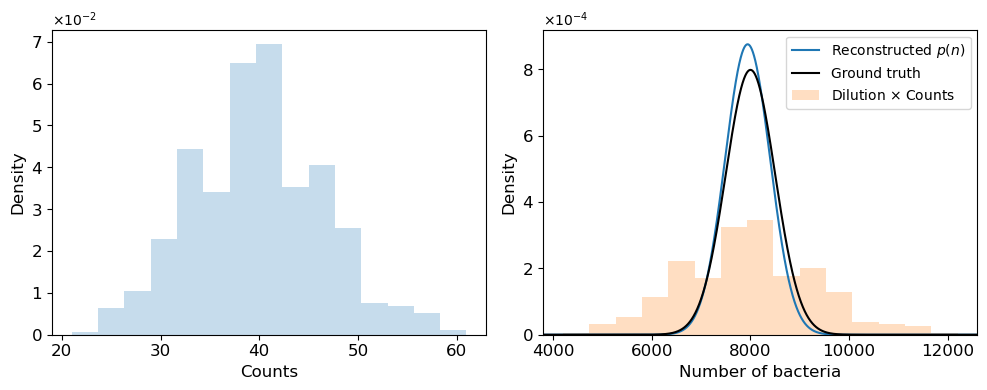

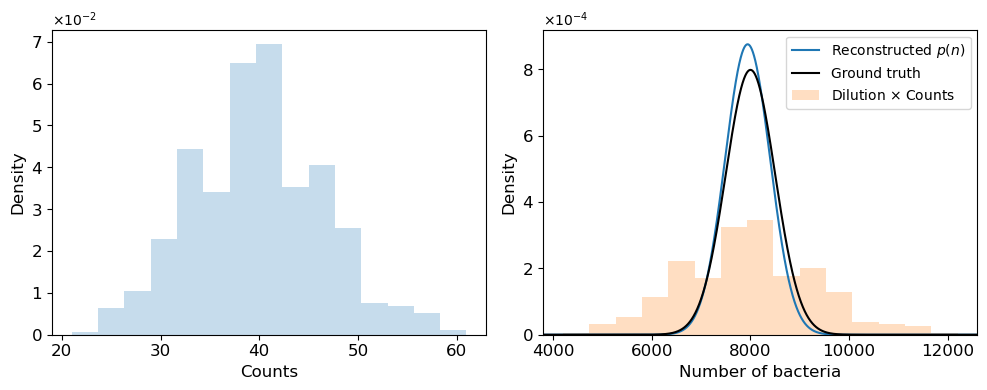

In [6]:
data.make_plot('graphs/synth/unimodal_{}.png'.format(th_gt.numpy()),th_gt)

In [7]:
del data.lpkdil_n
del data

In [8]:
data2 = load_dataset('synth_data/synth_multimodal_harder.csv',Nmax=1000,cutoff=-1)
th_gt = params2theta(*torch.tensor(((4000,8000,14000),
                                   (200,1500,1000),
                                   (.25,.4,.35))))


In [9]:
data2.loglike(th_gt.to(data2.device),th_gt.size(0)//3).sum()

tensor(-4346.6662, device='cuda:0', dtype=torch.float64)

In [10]:
data2.evaluate()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9a59890670>
Traceback (most recent call last):
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


4.939864818543354 -4350.18246793001 -585.8841483544813
4.917453517645686 -4345.933331950337 -569.9067048529316
4.903017551049154 -4345.854842287308 -555.9107261377674
4.890934632575089 -4344.827237109679 -544.9968783663785
tensor([-2.2218, -2.3641, -2.3999, -2.5976, -2.7470, -2.6285, -2.8845, -2.8636,
        -3.1098, -2.9227, -3.3989, -3.5208, -3.5844, -3.3837, -3.4978, -3.7021,
        -3.7532, -3.7304, -3.8565, -3.8369, -3.7708, -4.0246, -4.0547, -4.1639,
        -5.4211], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1.0632, device='cuda:0', dtype=torch.float64)
tensor([-2.2831, -2.4254, -2.4612, -2.6589, -2.6898, -2.8083, -2.9249, -2.9459,
        -2.9840, -3.1711, -3.4450, -3.4602, -3.5591, -3.5821, -3.6457, -3.7634,
        -3.7917, -3.8145, -3.8321, -3.8982, -3.9178, -4.0859, -4.1160, -4.2252,
        -5.4824], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1.0000, device='cuda:0', dtype=torch.float64)
4.879340634002496 -4344.930347980859 -5

(tensor([13893.1142,  8164.1805, 13862.6180,  8095.8841, 13771.9201,  8003.5203,
          4111.5587, 13598.5969,  4086.9720,  4110.0977,  7866.2475,  7433.5495,
          4025.2524,  3943.0662,  3989.1386,  4064.0335,  4249.3867,  5121.3530,
          3851.6405,  6014.3066,  4288.9965,  3203.1434, 11357.1521,  3459.4646,
          2010.9743], device='cuda:0', dtype=torch.float64),
 tensor([1251.8194,  925.1140, 1229.7262,  880.6574, 1339.2666,  962.5610,
          457.8589, 1486.5536,  482.7253,  519.6543, 1290.5925,  885.8598,
          509.7057,  472.7274,  538.0177,  645.0435,  823.3614, 1129.2668,
          611.9744, 1243.3039, 1038.5968,  442.5503, 1879.2507,  643.4720,
          517.0856], device='cuda:0', dtype=torch.float64),
 tensor([0.1252, 0.1079, 0.1010, 0.0864, 0.0800, 0.0614, 0.0605, 0.0568, 0.0426,
         0.0379, 0.0378, 0.0334, 0.0264, 0.0233, 0.0204, 0.0177, 0.0153, 0.0140,
         0.0116, 0.0112, 0.0075, 0.0071, 0.0064, 0.0059, 0.0025],
        device='cuda:0', dt

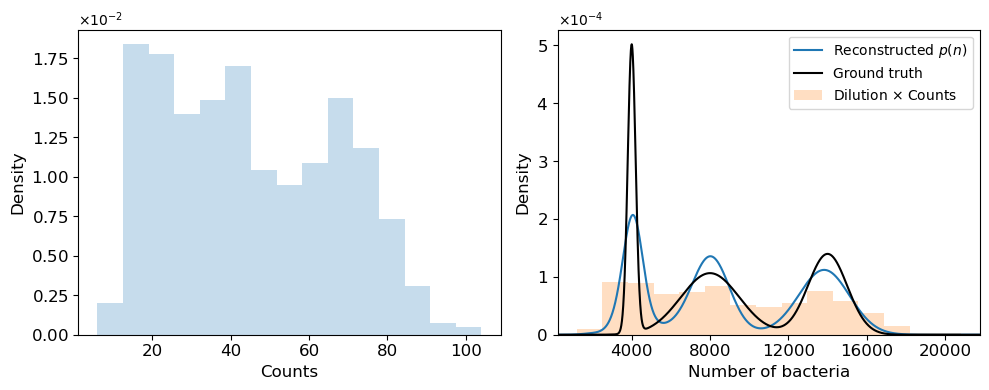

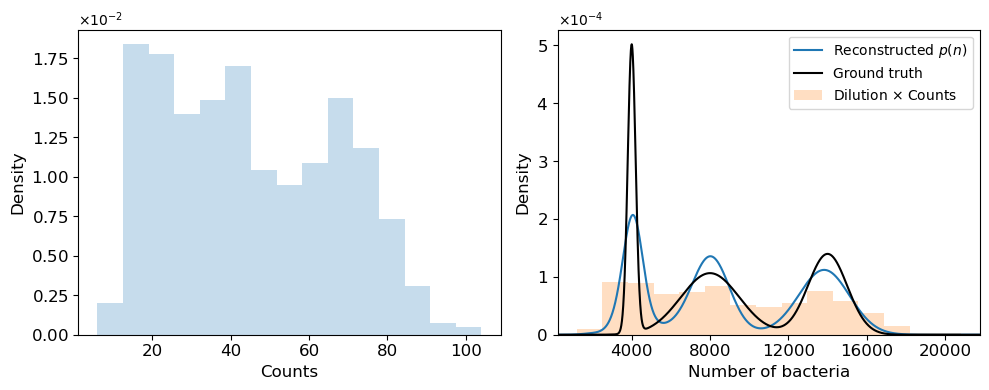

In [11]:
data2.make_plot('graphs/synth/multimodal_harder.png'.format(th_gt.numpy()),th_gt)

In [12]:
del data2.lpkdil_n
del data2

In [13]:
data3 = load_dataset('synth_data/synth_multimodal_easier.csv',Nmax=2000,cutoff=-1)
th_gt = params2theta(*torch.tensor(((8000,16000,24000),
                                   (1000,1000,1000),
                                   (.3,.2,.5))))

In [14]:
data3.loglike(th_gt.to(data3.device),th_gt.size(0)//3).sum()

tensor(-9397.8544, device='cuda:0', dtype=torch.float64)

In [15]:
data3.evaluate()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9a597608b0>
Traceback (most recent call last):
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/pessoa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


5.022027239207974 -9401.155029445308 -634.5062003802958
5.0082660163062585 -9393.627127791704 -621.7537119708668
5.002038915077809 -9392.53321270875 -610.3920378813514
4.996289033182688 -9391.630853180566 -599.906738677884
tensor([-2.1786, -2.2935, -2.4405, -2.5571, -2.6071, -2.7077, -3.0429, -2.9200,
        -3.0468, -2.8763, -3.2817, -3.4375, -3.1987, -3.4282, -3.7095, -3.8270,
        -3.7128, -3.8838, -3.8616, -3.9804, -4.0538, -4.0726, -4.2608, -5.1967,
        -6.2525], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1.0546, device='cuda:0', dtype=torch.float64)
tensor([-2.2317, -2.3466, -2.4937, -2.6103, -2.6602, -2.7608, -2.9294, -2.9731,
        -3.0960, -3.0999, -3.2519, -3.3348, -3.4813, -3.4907, -3.7626, -3.7659,
        -3.8801, -3.9147, -3.9369, -4.0336, -4.1070, -4.1258, -4.3139, -5.2498,
        -6.3057], device='cuda:0', dtype=torch.float64, requires_grad=True) tensor(1., device='cuda:0', dtype=torch.float64)
4.990835712466349 -9391.268761976258 -589.4

(tensor([23997.6496, 23980.6907, 23961.5311,  8089.3530,  8070.8101, 23879.3904,
          8063.2158, 16175.8814, 23789.1744, 23790.5211, 16107.7626,  7675.9413,
         16029.2772, 15963.4268,  7633.5128, 15814.2410, 15650.9102,  7639.8326,
          6660.1955, 14874.8630,  9754.5885,  6290.9848, 16370.7497,  8989.3902,
         30675.3692], device='cuda:0', dtype=torch.float64),
 tensor([ 995.2082, 1033.6610, 1089.4932,  716.9832,  717.0750, 1254.6145,
          715.7724, 1119.5149, 1413.7758, 1383.4214, 1130.3714,  694.0034,
         1240.6997, 1320.6393,  886.9336, 1338.2293, 1512.3879, 1036.3340,
          870.8549, 1650.7764, 1136.7357,  897.0286, 1691.5121, 1472.8004,
         2160.5302], device='cuda:0', dtype=torch.float64),
 tensor([0.1244, 0.1112, 0.0990, 0.0786, 0.0703, 0.0628, 0.0625, 0.0530, 0.0486,
         0.0432, 0.0371, 0.0299, 0.0289, 0.0253, 0.0211, 0.0195, 0.0167, 0.0142,
         0.0114, 0.0107, 0.0089, 0.0075, 0.0068, 0.0052, 0.0032],
        device='cuda:0', dt

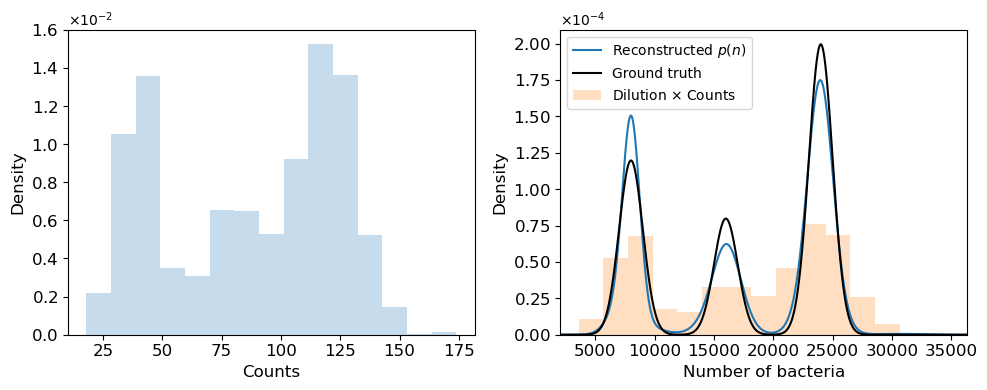

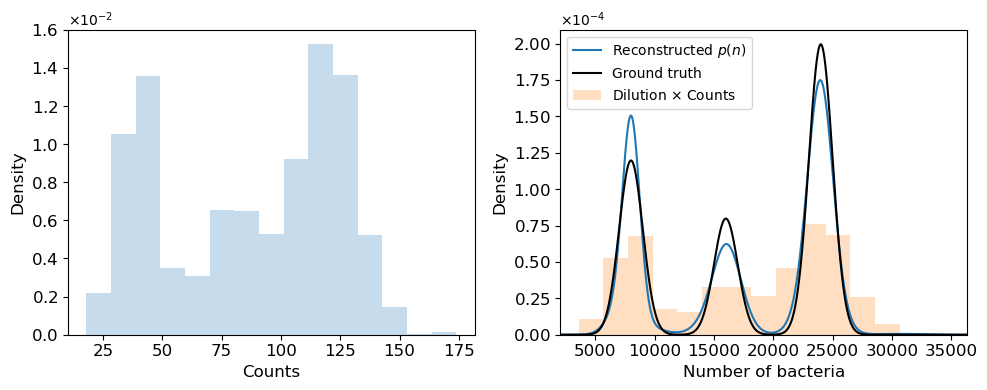

In [16]:
data3.make_plot('graphs/synth/multimodal_easier.png'.format(th_gt.numpy()),th_gt,xlabel='sci')